In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [38]:
%load_ext autoreload
%autoreload 2
import bnpm
import bnpm.plotting_helpers
import bnpm.path_helpers
import bnpm.timeSeries
import bnpm.ca2p_preprocessing
import bnpm.math_functions
import bnpm.h5_handling

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
paths_videos_exp = bnpm.path_helpers.find_paths('/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp', reMatch='exp_00001_')[:]
paths_videos_zstack = bnpm.path_helpers.find_paths('/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/zstack', reMatch='zstack')[:]

display(paths_videos_exp)
display(paths_videos_zstack)

['/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp/exp_00001_00001.tif',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp/exp_00001_00002.tif',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp/exp_00001_00003.tif',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp/exp_00001_00004.tif',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp/exp_00001_00005.tif',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp/exp_00001_00006.tif',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp/exp_00001_00007.tif',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp/exp_00001_00008.tif',
 '/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/exp/exp_00001_00009.tif',
 '/media/rich/bigSSD/downloads_tmp/tm

'/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/scanimage_data/20230321/zstack/zstack_815_00001_00001.tif'

In [14]:
frames_zstack = bnpm.ca2p_preprocessing.import_tiffs_SI(
    paths_videos_zstack[0],
    downsample_factors=[1,1,1], 
    clip_zero=True, 
    dtype=np.uint16, 
    verbose=True,
)

In [8]:
stack_out, positions_z, idx_slices = bnpm.ca2p_preprocessing.dense_stack_to_sparse_stack_SI(
    frames_zstack[0], 
    num_frames_per_slice=60, 
    num_slices=25, 
    num_volumes=10, 
    frames_to_discard_per_slice=30, 
    step_size_um=0.8, 
    sparse_step_size_um=0.8,
)

In [116]:
test = bnpm.ca2p_preprocessing.get_metadata(paths_videos_zstack)

In [108]:
good_stuff = [
    'SI.hStackManager.actualNumSlices',
    'SI.hStackManager.actualNumVolumes',
    'SI.hStackManager.actualStackZStepSize',
    'SI.hStackManager.framesPerSlice',
]

test2 = {}
for g in good_stuff:
    thing = np.array(test)[np.array([test[ii][:len(g)] == g for ii in range(len(test))])][0]
    idx_equals = thing.find('= ')
    test2.update({g: float(thing[idx_equals+2:])})
    

SI.hStackManager.actualNumSlices = 25 33
SI.hStackManager.actualNumVolumes = 10 34
SI.hStackManager.actualStackZStepSize = 0.8 38
SI.hStackManager.framesPerSlice = 60 32


In [ ]:
outs = [bnpm.ca2p_preprocessing.find_zShifts(
    stack_out,
    positions_z=positions_z,
    path_to_tiff=path,
    frames=None,
    clip_zero=True,
    downsample_factors=[1,1,1],
    dtype=np.uint16,
    bandpass_spatialFs_bounds=(0.02, 0.3),
    order_butter=5,
    use_GPU=True,
    batch_size=70,
    resample_factor=100,
    sig=4.0,
    verbose=True,
) for path in tqdm(paths_videos_exp[:1])]

positions_interp, zShift_interp, z_cc_interp = [[o[ii] for o in outs] for ii in range(3)]

positions_interp = np.concatenate(positions_interp).astype(np.float32)
z_cc_interp = np.concatenate(z_cc_interp, axis=0).astype(np.float32)
zShift_interp = zShift_interp[0].astype(np.float32)

<IPython.core.display.Javascript object>


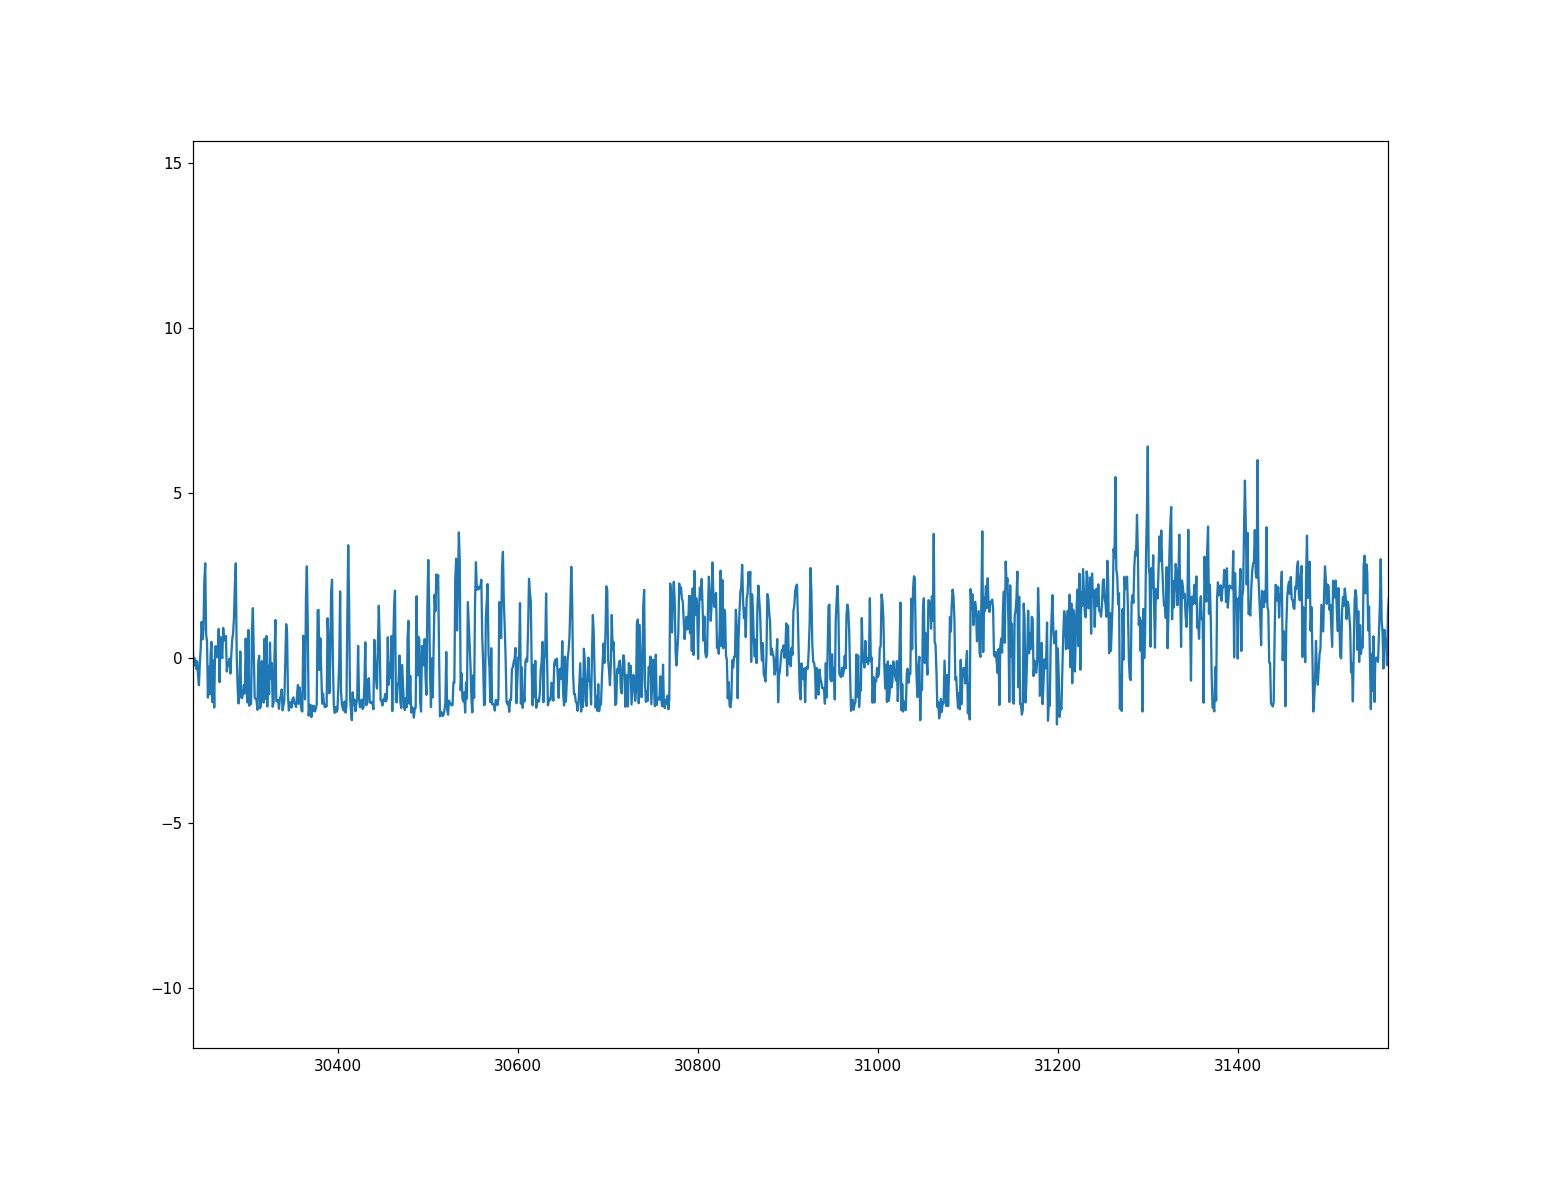

In [71]:
%matplotlib notebook
plt.figure()
plt.plot(positions_interp);

In [70]:
results = {
    'zPositions': positions_interp,
    'zAxis': zShift_interp,
}

bnpm.h5_handling.simple_save(
    dict_to_save=results,
    path='/media/rich/bigSSD/downloads_tmp/tmp_data/mouse_g8test/z_positions.h5',
    verbose=True,
)

==== Successfully wrote h5 file. Displaying h5 hierarchy ====
1. zPositions:      shape=(108000,) ,   dtype=float32
2. zAxis:           shape=(2500,) ,     dtype=float32


- threshold triggered average
- correlation with factor magnitudes (especially avgVec)